# LangGraph Components
LangGraph support graphs
* nodes: Agents or functions
* Edges: connect nodes
* Conditional edges: decisions
* Agent state: This is a state that is tracked all the time and accessible to all parts of the graph

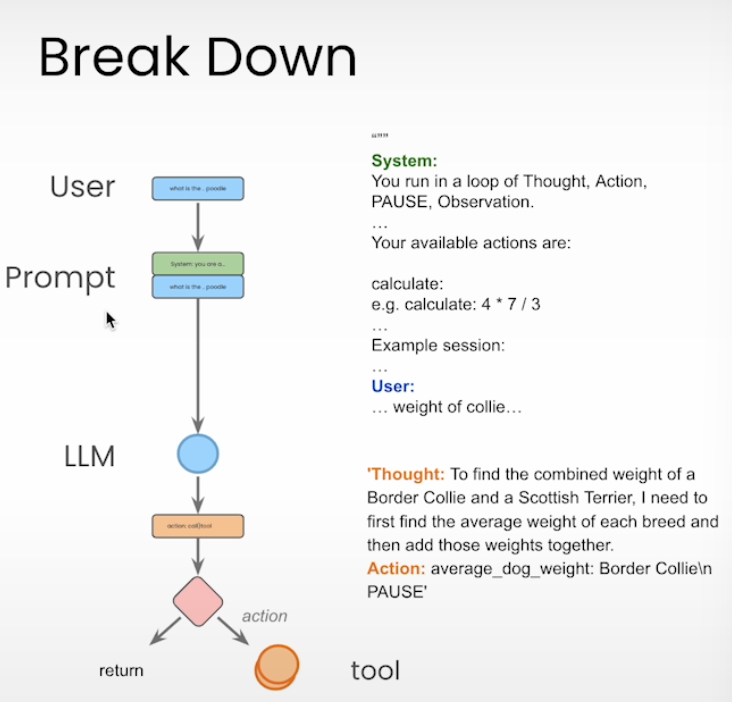

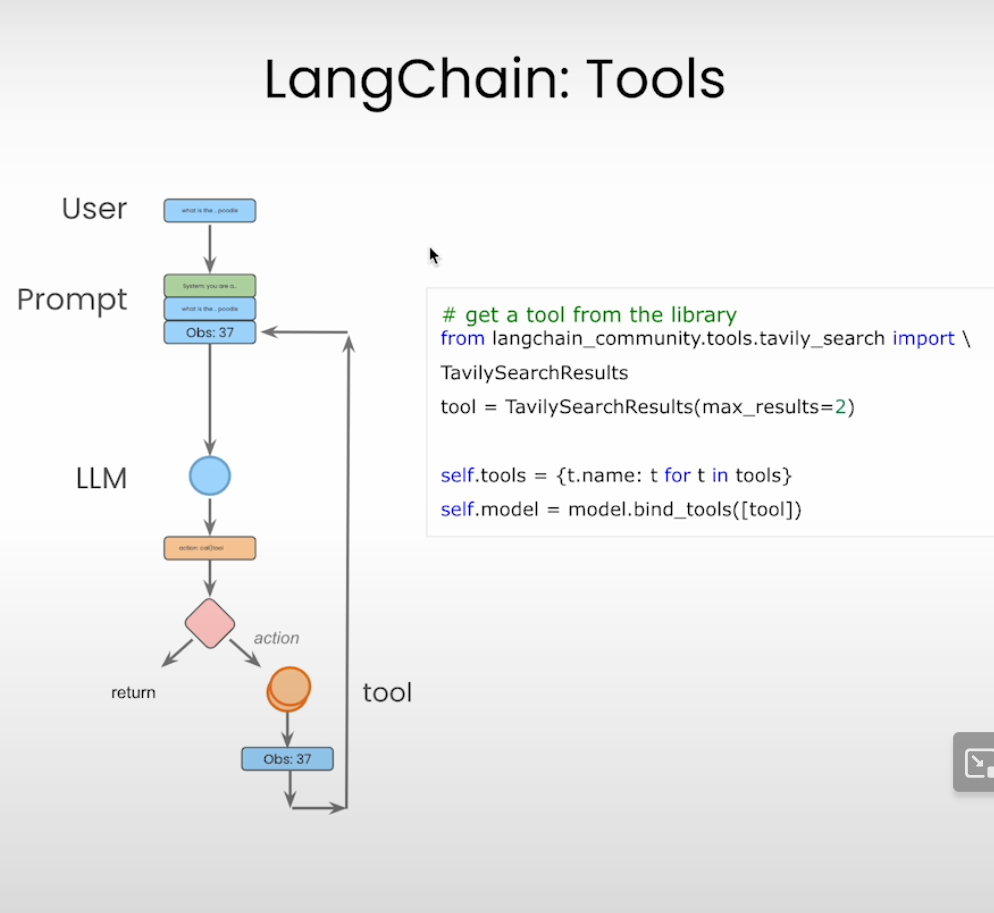

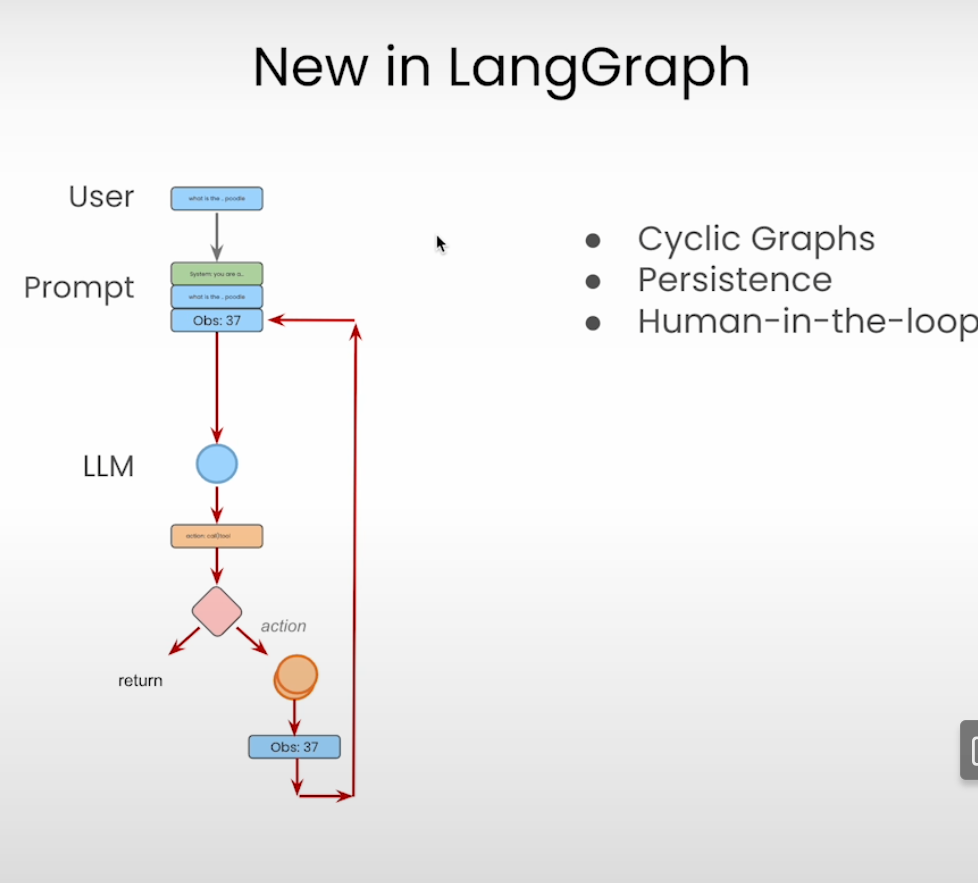

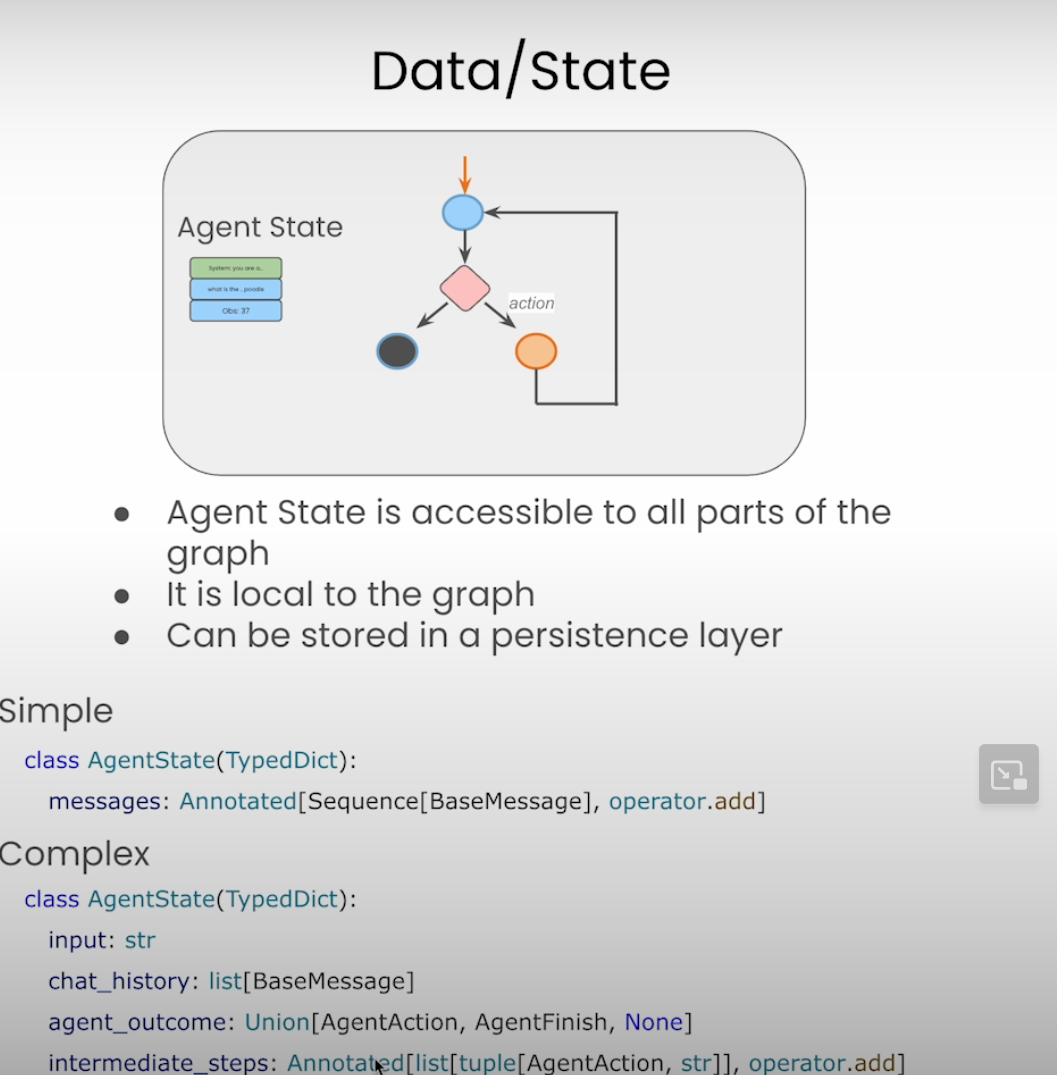

In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
tool = TavilySearchResults(max_results=2)
print(type(tool))
print(tool.name) # tavily_search_results_json is the name of the language model we will use to call this tool


<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


If you are not familiar with python typing annotation, you can refer to the python documents.

https://docs.python.org/3/library/typing.html

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [14]:
class Agent:
    """We need three functions
    * the first function call the LLM
    * the second function checks if there is an action to take
    * the last function call the action
    """
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai) # add a function to execute the LLM
        graph.add_node("action", self.take_action) # add a function to represent this node
        graph.add_conditional_edges( 
            # this will check if there is an action not, if none, then it will got to end node
            "llm",
            self.exists_action, # a function that will determine where to go after llm
            {True: "action", False: END} # if the function returns True, then we go to action node, if false then we go to end
        )
        graph.add_edge("action", "llm") # the first argument is the start of an edge while the second is the end of the edge
        graph.set_entry_point("llm")
        self.graph = graph.compile() # this convert it into a langchain runnable
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools) # this let the model know that there tools available to run
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0 
    
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages':[message]}
    
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

    


In [15]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost


In [16]:
abot = Agent(model, [tool], system=prompt)

In [21]:
from IPython.display import Image
#Image(abot.graph.get_graph().draw_png())

In [22]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hwFHIoSiMoY6pqm7GVrx0AmE', 'type': 'tool_call'}
Back to the model!


In [25]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hwFHIoSiMoY6pqm7GVrx0AmE', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b7eedad6-2c33-4923-adeb-1f82780490ed-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hwFHIoSiMoY6pqm7GVrx0AmE', 'type': 'tool_call'}], usage_metadata=

In [24]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 60.1°F (15.6°C). The wind speed is around 18.4 km/h coming from the east-northeast direction. The humidity is at 53%, and there is no precipitation at the moment.'

In [28]:
messages = [HumanMessage(content="What is the weather in SF and Kigali?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_qhBoOkraX9SI7BhLkhIiMxcF', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Kigali'}, 'id': 'call_zaUeVC0CgbYoYPLFCmSp0qQi', 'type': 'tool_call'}
Back to the model!


In [29]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 62.1°F (16.7°C) and a slight wind from the east-northeast at 18.4 km/h. The humidity is at 20%.\n\nIn Kigali, the current weather is partly cloudy with a temperature of 61.2°F (16.2°C) and a light wind from the west-northwest at 4.7 km/h. The humidity is at 100%.'

In [30]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_eVYyQOqu5Nx49J8DSmTwBHEv', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_Y4ER1tXYTmuNUQIo2cv22F2a', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_ZG67QfB9i0BWzlioD3KpBCgn', 'type': 'tool_call'}
Back to the model!


In [31]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs' headquarters is located in Missouri.

3. **What is the GDP of that state?**
   - The GDP of Missouri in the third quarter of 2024 was approximately $454,580 million (or $454.58 billion).
